<a href="https://colab.research.google.com/github/hoangdungnguyen/PL_deeplearning/blob/master/dropoutNN%2BPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import StratifiedShuffleSplit

mnist = input_data.read_data_sets("", one_hot=True)


In [0]:
stratSplit = StratifiedShuffleSplit(test_size=100, random_state=2812, n_splits=1)
stratSplit.get_n_splits(mnist.train.images, np.argmax(mnist.train.labels, axis = 1))
for train_index, test_index in stratSplit.split(X = mnist.train.images,y = mnist.train.labels):
  x_train = mnist.train.images[test_index]
  y_train = mnist.train.labels[test_index]
  x_PL = mnist.train.images[train_index]

print('Labeled data size :', x_train.shape)
print('Unlabeled data size :', x_PL.shape)
print('Proportion of class label in train data: ')
pd.DataFrame(np.unique(np.argmax(y_train,1), return_counts = True))

Labeled data size : (100, 784)
Unlabeled data size : (54900, 784)
Proportion of class label in train data: 


,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,10,11,10,10,10,9,10,10,10,10


In [0]:
tf.test.is_gpu_available()

True

In [0]:
##### Define hyper-parameters #####

# Dropout parameters
dropoutRate_0 = 0.
dropoutRate_1 = 0.5 #ref

# NN parameters
inputN = 784 #default
hiddenN = 5000 #ref 
outputN = 10 #default

# DAE_NN parameters
DAE_hiddenN1 = 256 # ref
DAE_hiddenN2 = 128
DAE_hiddenN3 = 256
destruction_proportion = 0.5 # ref
trainingEpochsDAE = 50
batch_sizeDAE = 256

# iteraction parameters
trainingEpochs = 3000 #ref
batchSize = 32 # ref
PLbatchSize = 256 #ref

# balancing coefficient
T1 = 100 #ref
T2 = 600 #ref
a = 0. #ref
af = 3. #ref

T1_DAE = 200 #ref
T2_DAE = 800 #ref

# SGD with dynamic momentum
learningRate = 1.5 # ref
T = 500 #ref
k = 0.998 #ref
pi = 0.5 #ref
pf = 0.99 #ref


In [0]:
##### Define NN architecture ####

x = tf.placeholder("float", [None, inputN])
y = tf.placeholder("float", [None, outputN])
PLx = tf.placeholder("float", [None, inputN])
PLy = tf.placeholder("float", [None, outputN])
DAE_x = tf.placeholder("float", [None, inputN])
DAE_x_noise = tf.placeholder("float", [None, inputN])
alpha_t = tf.placeholder("float", )
p_t = tf.placeholder("float",)
epsilon_t = tf.placeholder("float",)
plt.clf()

def NN(x, w, b):
    # Hidden layer 1
    HL = tf.add(tf.matmul(x, w['h1']), b['b1'])
    HL = tf.nn.relu(HL)
    HL = tf.nn.dropout(HL, rate = dropoutRate_1)
    # Output layer
    out_layer =tf.matmul(HL, w['out']) + b['out']

    return out_layer

def DAE_NN(DAE_x_noise, w, b):
  # Hidden layer 1
  HL1 = tf.nn.sigmoid(tf.add(tf.matmul(DAE_x_noise, w['h1']), b['b1']))
  #HL1 = tf.nn.dropout(HL1, rate = dropoutRate_1)
  # Hidden layer 2
  HL2 = tf.nn.sigmoid(tf.add(tf.matmul(HL1, w['h2']), b['b2']))
  #HL2 = tf.nn.dropout(HL2, rate = dropoutRate_1)
  # Hidden layer 3
  HL3 = tf.nn.sigmoid(tf.add(tf.matmul(HL2, w['h3']), b['b3']))
  #HL3 = tf.nn.dropout(HL3, rate = dropoutRate_1)
  # Output layer
  out_layer = tf.nn.sigmoid(tf.add(tf.matmul(HL3, w['out']), b['out']))
  
  return out_layer


# initialize weights and biases
with tf.variable_scope('NN') :
  weightsNN = {
    'h1': tf.Variable(tf.random_normal([inputN, hiddenN])),
    'out': tf.Variable(tf.random_normal([hiddenN, outputN]))
    }

  biasesNN = {
    'b1': tf.Variable(tf.random_normal([hiddenN])),
    'out': tf.Variable(tf.random_normal([outputN]))
    }

with tf.variable_scope('PL') :
  weightsPL = {
    'h1': tf.Variable(tf.random_normal([inputN, hiddenN])),
    'out': tf.Variable(tf.random_normal([hiddenN, outputN]))
    }
  biasesPL = {
    'b1': tf.Variable(tf.random_normal([hiddenN])),
    'out': tf.Variable(tf.random_normal([outputN]))
    }

with tf.variable_scope('DAE') :
  weightsDAE = {
    'h1': tf.Variable(tf.random_normal([inputN, DAE_hiddenN1])),
    'h2': tf.Variable(tf.random_normal([DAE_hiddenN1, DAE_hiddenN2])),
    'h3': tf.Variable(tf.random_normal([DAE_hiddenN2, DAE_hiddenN3])),
    'out': tf.Variable(tf.random_normal([DAE_hiddenN3, inputN]))
    }
  biasesDAE = {
    'b1': tf.Variable(tf.random_normal([DAE_hiddenN1])),
    'b2': tf.Variable(tf.random_normal([DAE_hiddenN2])),
    'b3': tf.Variable(tf.random_normal([DAE_hiddenN3])),
    'out': tf.Variable(tf.random_normal([inputN]))
    }

predDAE = DAE_NN(DAE_x_noise, weightsDAE, biasesDAE)

costDAE = tf.reduce_mean(tf.compat.v1.losses.log_loss(DAE_x, predDAE))

predNN = NN(x, weightsNN, biasesNN)
predPL = NN(x, weightsPL, biasesPL)
predPL1 = NN(PLx, weightsPL, biasesPL)

costNN = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predNN,
                                                                labels=y))

costPL = tf.add(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predPL,
                                                                       labels=y)),
                (alpha_t * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predPL1,
                                                                                labels=PLy))))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<Figure size 432x288 with 0 Axes>

In [0]:
##### Define optimizer #####

optimizerNN = tf.train.MomentumOptimizer(learning_rate = (1-p_t)*epsilon_t,
                                        momentum = -p_t/(1-p_t)).minimize(costNN)
optimizerPL = tf.train.MomentumOptimizer(learning_rate = (1-p_t)*epsilon_t,
                                        momentum = -p_t/(1-p_t)).minimize(costNN)

# Initializing the variables
init = tf.global_variables_initializer()

In [0]:
##### Define benchmark functions #####

def accuracytestNN():
    # Test model
    correct_prediction = tf.equal(tf.argmax(predNN, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    # To keep sizes compatible with model
    return accuracy.eval({x: mnist.test.images, y: mnist.test.labels})


def accuracytestPL():
    # Test model
    correct_prediction = tf.equal(tf.argmax(predPL, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    # To keep sizes compatible with model
    return accuracy.eval({x: mnist.test.images, y: mnist.test.labels})


In [0]:
def dropNN_PL():
  ### Neural Network parameters
  iteration_list = []
  neural_network_accuracy_list = []
  pseudo_label_accuarcy_list = []
  neural_network_accuracy = 0
  pseudo_label_accuarcy = 0
  iteration = 0
  with tf.Session() as sess:
    sess.run(init)
    begin=time.time()
    # Training cycle
    for epoch in range(trainingEpochs):
        avg_costNN = 0.
        avg_costPL = 0.
        total_batch = int(100 / batchSize)
        # Loop over all batches
        index = np.arange(x_train.shape[0])
        np.random.shuffle(index)
        batches_X = np.array_split(x_train[index], total_batch)
        batches_y = np.array_split(y_train[index], total_batch)
        index = np.arange(x_PL.shape[0])
        np.random.shuffle(index)
        batches_X_PL = np.array_split(x_PL[index], total_batch)
        for i in range(total_batch):
            batch_x, batch_y = batches_X[i], batches_y[i]
            if epoch > T:
              p = pf
            else:
              p = epoch/T*pf + (1-epoch/T)*pi

            _, cNN = sess.run([optimizerNN, costNN], feed_dict={x: batch_x,
                                                                y: batch_y,
                                                                p_t : p,
                                                                epsilon_t : learningRate*(k**epoch)
                                                                })
            if epoch < T1:
                a = 0
            elif epoch < T2:
                a = ((epoch - T1) / (T2 - T1)) * af
            else :
                a = af
            

            # Pseudolabel
            batch_xpred = batches_X_PL[i]
            batch_ypred = sess.run([predPL], feed_dict={x: batch_xpred})
            batch_ypred = batch_ypred[0]
            batch_ypred = batch_ypred.argmax(1)
            batch_ypre = np.zeros((batch_xpred.shape[0], 10))
            for ii in range(PLbatchSize):
                batch_ypre[ii, batch_ypred[ii]] = 1

            _, cPL = sess.run([optimizerPL, costPL], feed_dict={x: batch_x,
                                                                y: batch_y,
                                                                PLx: batch_xpred,
                                                                PLy: batch_ypre,
                                                                p_t : p,
                                                                epsilon_t : learningRate*(k**epoch),
                                                                alpha_t: a})
            iteration += 1
            # Compute average loss
            avg_costNN += cNN / total_batch
            avg_costPL += cPL / total_batch

        if epoch % 100 == 0:
            neural_network_accuracy = accuracytestNN()
            pseudo_label_accuarcy = accuracytestPL()
            print("Epoch {} | time = {:.4f} | DropNN acc = {:.4f} | DropNN+PL acc = {:.4f} "
                  .format(epoch, time.time() - begin,
                          neural_network_accuracy, pseudo_label_accuarcy))

            iteration_list = np.append(iteration_list, iteration)
            neural_network_accuracy_list = np.append(neural_network_accuracy_list, neural_network_accuracy)
            pseudo_label_accuarcy_list = np.append(pseudo_label_accuarcy_list, pseudo_label_accuarcy)

        plt.plot(iteration_list, pseudo_label_accuarcy_list, iteration_list, neural_network_accuracy_list, 'r--')
    print("Optimization Finished!")
    print("Neural Network accuracy:", accuracytestNN())
    print("+PL:", accuracytestPL())
    plt.show()

Epoch 0 | time = 0.5472 | DropNN acc = 0.2174 | DropNN+PL acc = 0.1021 
Epoch 100 | time = 31.0627 | DropNN acc = 0.0892 | DropNN+PL acc = 0.1047 
Epoch 200 | time = 61.7149 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1021 
Epoch 300 | time = 92.2135 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1018 
Epoch 400 | time = 122.7676 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1100 
Epoch 500 | time = 153.3870 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1067 
Epoch 600 | time = 184.0832 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1032 
Epoch 700 | time = 214.7156 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1080 
Epoch 800 | time = 245.5348 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1025 
Epoch 900 | time = 276.2127 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1061 
Epoch 1000 | time = 306.9373 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1007 
Epoch 1100 | time = 337.6623 | DropNN acc = 0.0980 | DropNN+PL acc = 0.1068 
Epoch 1200 | time = 368.4486 | DropNN acc = 0.0980 | DropNN+PL acc = 0.0973 
Epoch 1300 | tim

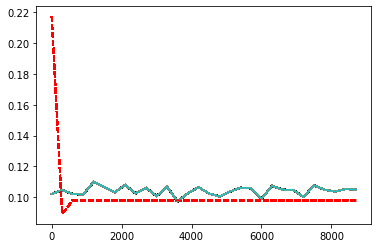

In [16]:
dropNN_PL()